In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [331]:
from preprocessing import load_csv_data, remove_na_columns, remove_low_variance_features,\
    remove_correlated_features, z_normalize_data, augment_features_polynomial_basis, split_data_by_categorical_column, min_max_normalize_data

In [425]:
def preprocessing(data, *, nan_value=-999., low_var_threshold=0.1, corr_threshold=0.85, deg=3):
    data = data.copy()
    data[data == nan_value] = np.nan
    data = remove_na_columns(data)
    # data = remove_low_variance_features(data, low_var_threshold)
    data = remove_correlated_features(data, corr_threshold)
    data = z_normalize_data(data)
    data[np.isnan(data)] = 0.
    data = augment_features_polynomial_basis(data, deg)
    return data

In [338]:
PRI_JET_NUM_INDEX = 22
SEED = 2019

In [ ]:
train_classes, train_data, train_ids = load_csv_data("data/train.csv")
#test_classes, test_data, test_ids = load_csv_data("data/test.csv")

train_classes_jet_num_splits, train_data_jet_num_splits, train_ids_jet_num_splits = \
    split_data_by_categorical_column(train_classes,
                                     train_data,
                                     train_ids,
                                     PRI_JET_NUM_INDEX)

In [454]:
from implementations import reg_logistic_regression, svm, ridge_regression
from helpers import compute_loss_nll, predict_labels, compute_accuracy, compute_loss
from cross_validation import k_fold_cross_split_data

In [456]:
POSSIBLE_LAMBDA_VALUES = np.logspace(-5, -2, 5)
POSSIBLE_DEGREES = np.arange(1, 8)
grid_shape = (4, len(POSSIBLE_DEGREES), len(POSSIBLE_LAMBDA_VALUES), 2)

train_loss_matrix = np.zeros(grid_shape)
validation_loss_matrix = np.zeros(grid_shape)

for jet_num, (train_classes_split, train_data_split) in enumerate(zip(train_classes_jet_num_splits, train_data_jet_num_splits)):
    for i, deg in enumerate(POSSIBLE_DEGREES):
        train_data_split = preprocessing(train_data_split, deg=deg)
        train_set_folds = k_fold_cross_split_data(train_classes_split, train_data_split, 10, SEED)
        for j, lambda_ in enumerate(POSSIBLE_LAMBDA_VALUES): #tqdm_notebook
            print(jet_num, i, j)
            folds_train_losses = []
            folds_validation_losses = []
            for x_train, y_train, x_test, y_test in train_set_folds:
                w, train_loss = ridge_regression(y_train, x_train, lambda_)
                folds_train_losses.append(train_loss)
                validation_loss = compute_loss(y_test, x_test, w)
                folds_validation_losses.append(validation_loss)
            train_loss_matrix[jet_num, i, j] = (np.mean(folds_train_losses), np.std(folds_train_losses))
            validation_loss_matrix[jet_num, i, j] = (np.mean(folds_validation_losses), np.std(folds_validation_losses))

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 6 0
1 6 1
1 6 2
1 6 3
1 6 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
2 5 0
2 5 1
2 5 2
2 5 3
2 5 4
2 6 0
2 6 1
2 6 2
2 6 3
2 6 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
3 5 0
3 5 1
3 5 2
3 5 3
3 5 4
3 6 0
3 6 1
3 6 2
3 6 3
3 6 4


In [465]:
def plot_grid_search_results(loss_array, lambdas, degrees):
    plt.figure(figsize=(8,10))
    plt.imshow(np.log(loss_array))
    plt.colorbar(orientation='horizontal')
    plt.xticks(np.arange(degrees.shape[0]), degrees, rotation=20)
    plt.yticks(np.arange(lambdas.shape[0]), lambdas, rotation=20)
    plt.xlabel('degree')
    plt.ylabel('lambda')
    plt.title('Validation loss for different lambda and degree')
    plt.show()

In [434]:
def find_best_hyperparameters(error_values, lambdas, degrees):
    """ A function which finds the hyperparameters that give the lowest error
        
    Args:
        error_values (np.array) Cross-validation error values of all different 
        combinations of hyperparameters.
        lambdas (np.array): Array of different regularization coefficients to try.
        degrees (np.array): Array of different degrees coefficients to try for 
        feature expansion.

    Returns:
        (float), (int): Lambda and degree combination that result in lowest error
    """    
    #######################################
    # Please fill in the required code here
    best_lmbda, best_deg = np.unravel_index(np.argmin(error_values), error_values.shape)
    # Extract the lambda and degree resulting in the lowest error.
    degree_best = degrees[best_deg]
    lambda_best = lambdas[best_lmbda]
    
    #######################################
    return lambda_best, degree_best

In [480]:
best_hyper = [find_best_hyperparameters(validation_loss_matrix[i, :, :, 0], POSSIBLE_LAMBDA_VALUES, POSSIBLE_DEGREES) for i in range(4)]
best_hyper

[(1e-05, 1),
 (0.00031622776601683794, 5),
 (5.623413251903491e-05, 4),
 (5.623413251903491e-05, 3)]

In [443]:
cpy2 = train_loss_matrix.copy()
cpy2[cpy2>1] = 1

In [479]:
validation_loss_matrix[0, :, :]

array([[[2.93325923e-01, 5.28934407e-03],
        [2.93327774e-01, 5.29124088e-03],
        [2.93338367e-01, 5.30206311e-03],
        [2.93403035e-01, 5.36703778e-03],
        [2.93860501e-01, 5.76648135e-03]],

       [[1.93004210e+00, 4.93027848e+00],
        [1.92590140e+00, 4.91785324e+00],
        [1.90278085e+00, 4.84847224e+00],
        [1.77797546e+00, 4.47390395e+00],
        [1.22684088e+00, 2.81925756e+00]],

       [[3.87489901e+07, 1.16246642e+08],
        [1.22129610e+06, 3.66356075e+06],
        [3.29129335e+04, 9.84172601e+04],
        [2.35512608e+02, 4.89282146e+02],
        [1.36623448e+03, 3.93006048e+03]],

       [[6.04366213e+11, 1.81287555e+12],
        [2.02636691e+11, 6.07688112e+11],
        [1.79092975e+11, 5.37055826e+11],
        [9.95084022e+10, 2.98289554e+11],
        [1.41897275e+10, 4.23224250e+10]],

       [[6.99136813e+11, 2.09738334e+12],
        [6.94065032e+11, 2.08219398e+12],
        [6.69946673e+11, 2.00983987e+12],
        [5.46468213e+11, 1

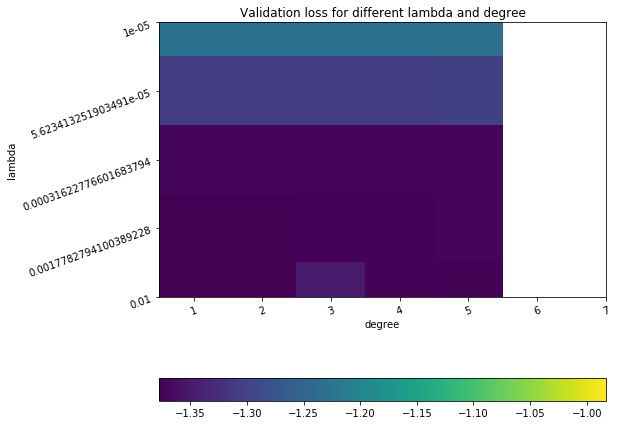

In [475]:
plot_grid_search_results(train_loss_matrix[0, :, :, 0], POSSIBLE_LAMBDA_VALUES, POSSIBLE_DEGREES)

In [481]:
models = []
for (lambda_, deg), train_classes_split, train_data_split in zip(best_hyper, train_classes_jet_num_splits, train_data_jet_num_splits):
    data_split = preprocessing(train_data_split, deg=deg)
    initial_w = np.zeros((data_split.shape[1],))
    print(initial_w.shape)
    w, loss = ridge_regression(train_classes_split, data_split, lambda_)
    print(f'Loss: {loss:.3f} Accuracy : {compute_accuracy(predict_labels(w, data_split), train_classes_split)}')
    # w, loss = reg_logistic_regression(train_classes_split, data_split, 1e-3, initial_w, 1001, 1e-5)
    # w, loss = svm(train_classes_split, data_split, 1e-3, initial_w, 1001, 1e-5)#5e-8)
    #print(w, loss)
    models.append((w, loss))

(15,)
Loss: 0.292 Accuracy : 0.7988550038533524
(76,)
Loss: 0.331 Accuracy : 0.7685829980398226
(85,)
Loss: 0.312 Accuracy : 0.7914805772246373
(67,)
Loss: 0.329 Accuracy : 0.7693105937556398


In [440]:
cpy = validation_loss_matrix.copy()
cpy[cpy>1] = 1

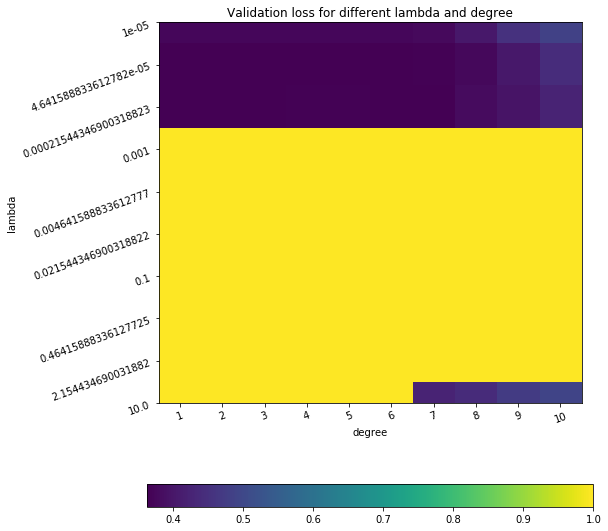

In [441]:
plot_grid_search_results(cpy[:, :, 0], POSSIBLE_LAMBDA_VALUES, POSSIBLE_DEGREES)

In [424]:
models = []
for i in range(1, 12):
    print('i', i)
    for train_classes_split, train_data_split in zip(train_classes_jet_num_splits, train_data_jet_num_splits):
        data_split = preprocessing(train_data_split, deg=i)
        initial_w = np.zeros((data_split.shape[1],))
        print(initial_w.shape)
        w, loss = ridge_regression(train_classes_split, data_split, 1e-4)
        print(f'Loss: {loss:.3f} Accuracy : {compute_accuracy(predict_labels(w, data_split), train_classes_split)}')
        # w, loss = reg_logistic_regression(train_classes_split, data_split, 1e-3, initial_w, 1001, 1e-5)
        # w, loss = svm(train_classes_split, data_split, 1e-3, initial_w, 1001, 1e-5)#5e-8)
        #print(w, loss)
        models.append((w, loss))

i 1
(19,)
Loss: 0.272 Accuracy : 0.8168806861969914
(23,)
Loss: 0.373 Accuracy : 0.7103708862065408
(30,)
Loss: 0.355 Accuracy : 0.7339566089045039
(30,)
Loss: 0.359 Accuracy : 0.7228388377549179
i 2
(37,)
Loss: 0.253 Accuracy : 0.8256983575710869
(45,)
Loss: 0.339 Accuracy : 0.7560610750025791
(59,)
Loss: 0.323 Accuracy : 0.7764941741598682
(59,)
Loss: 0.332 Accuracy : 0.759565060458401
i 3
(55,)
Loss: 0.245 Accuracy : 0.8297819102619278
(67,)
Loss: 0.330 Accuracy : 0.7657458991024451
(88,)
Loss: 0.304 Accuracy : 0.7965620595883205
(88,)
Loss: 0.312 Accuracy : 0.791238043674427
i 4
(73,)
Loss: 0.241 Accuracy : 0.8325643309679421
(89,)
Loss: 0.322 Accuracy : 0.7765010832559579
(117,)
Loss: 0.296 Accuracy : 0.8060302903987773
(117,)
Loss: 0.303 Accuracy : 0.8023822414726584
i 5
(91,)
Loss: 0.238 Accuracy : 0.8367579794421146
(111,)
Loss: 0.318 Accuracy : 0.780434334055504
(146,)
Loss: 0.292 Accuracy : 0.8090275710117311
(146,)
Loss: 0.301 Accuracy : 0.8044125609095831
i 6
(109,)
Loss: 0

In [410]:
models = []
for i in range(1, 8):
    print('i', i)
    for train_classes_split, train_data_split in zip(train_classes_jet_num_splits, train_data_jet_num_splits):
        data_split = preprocessing(train_data_split, deg=i)
        initial_w = np.zeros((data_split.shape[1],))
        print(initial_w.shape)
        w, loss = ridge_regression(train_classes_split, data_split, 1e-2)
        print(f'Loss: {loss:.3f} Accuracy : {compute_accuracy(predict_labels(w, data_split), train_classes_split)}')
        # w, loss = reg_logistic_regression(train_classes_split, data_split, 1e-3, initial_w, 5001, 1e-5)
        # w, loss = svm(train_classes_split, data_split, 1e-3, initial_w, 10001, 1e-5)#5e-8)
        #print(w, loss)
        models.append((w, loss))

i 1
(17,)
Loss: 0.292 Accuracy : 0.80194769449421
(19,)
Loss: 0.383 Accuracy : 0.7023109460435366
(25,)
Loss: 0.362 Accuracy : 0.7277635522737649
(26,)
Loss: 0.366 Accuracy : 0.7195903266558383
i 2
(33,)
Loss: 0.265 Accuracy : 0.8162901724500315
(37,)
Loss: 0.350 Accuracy : 0.739257711750748
(49,)
Loss: 0.337 Accuracy : 0.7535282558208778
(51,)
Loss: 0.339 Accuracy : 0.7513986645009926
i 3
(49,)
Loss: 0.254 Accuracy : 0.8213145436529781
(55,)
Loss: 0.343 Accuracy : 0.7456153925513257
(73,)
Loss: 0.327 Accuracy : 0.7659143690823558
(76,)
Loss: 0.329 Accuracy : 0.7653853095109187
i 4
(65,)
Loss: 0.251 Accuracy : 0.8233863461211254
(73,)
Loss: 0.340 Accuracy : 0.7496518105849582
(97,)
Loss: 0.317 Accuracy : 0.7795510033942714
(101,)
Loss: 0.320 Accuracy : 0.7745894242916441
i 5
(81,)
Loss: 0.249 Accuracy : 0.8262388277801688
(91,)
Loss: 0.334 Accuracy : 0.7595816568657794
(121,)
Loss: 0.308 Accuracy : 0.79086524146966
(126,)
Loss: 0.315 Accuracy : 0.7805901461829995
i 6
(97,)
Loss: 0.244 

In [265]:
test_classes, test_data, test_ids = load_csv_data("data/test.csv")

In [287]:
test_classes_jet_num_splits, test_data_jet_num_splits, test_ids_jet_num_splits = \
    split_data_by_categorical_column(test_classes,
                                     test_data,
                                     test_ids,
                                     PRI_JET_NUM_INDEX)

In [483]:
results = None
for (w, _), (_, deg), test_classes_split, test_data_split, test_ids_split in zip(models, best_hyper, test_classes_jet_num_splits, test_data_jet_num_splits, test_ids_jet_num_splits):
    data_split = preprocessing(test_data_split, deg=deg)
    pred = predict_labels(w, data_split)
    print(pred.shape)
    out = np.stack((test_ids_split, pred), axis=-1)
    print(out.shape)
    results = out if results is None else np.vstack((results, out))
    
print(results.shape)

(227458,)
(227458, 2)
(175338,)
(175338, 2)
(114648,)
(114648, 2)
(50794,)
(50794, 2)
(568238, 2)


In [484]:
from helpers import create_csv_submission

create_csv_submission(results[:, 0], results[:, 1], 'results3.csv')